In [1]:
from psycopg2 import connect
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DB Connection
CONFIG = configparser.ConfigParser(interpolation=None)
CONFIG.read('./ttc_db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

### Headway calculation data

Create view with one row per train station arrival with data for that train and the arrival time data of the following train (request date and timint).

Main cleaning steps of this view are:
* only look at first train expected to arrive at the station
* discard all rows in which the following request still has the same train arriving
* filter for subway hours (weekdays vs sunday, but no special treatment for holiday hours)
* create a window to only look inside each day (adjusting time by 2 hours to compensate for the end of service after midnight)

In [3]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS headway_data CASCADE; 
CREATE MATERIALIZED VIEW headway_data AS 
WITH ordered_trains AS (
  SELECT subwayline, station_char, trainid, timint, requestid,
  RANK() OVER (PARTITION BY subwayline, station_char, requestid ORDER BY timint, trainid) as train_order
  FROM ntas_data
), closest_trains AS (
  SELECT subwayline, station_char, trainid, timint, requestid
  FROM ordered_trains
  WHERE train_order = 1
), valid_trains_next AS (
  SELECT subwayline, station_char, trainid, timint, requestid, request_date,
    DATE(request_date - INTERVAL '3 hours') as adj_date,
    LEAD(trainid) OVER (PARTITION BY subwayline, station_char, DATE(request_date - INTERVAL '3 hours') ORDER BY request_date, requestid) as next_train
  FROM closest_trains
  JOIN requests USING (requestid)
  WHERE (request_date::time <= '01:30:00'::time
   OR ((extract(dow from request_date) > 0 AND extract(hour from request_date) >= 6)
   OR (extract(dow from request_date) = 0 AND extract(hour from request_date) >= 8)
   ))
)
  SELECT subwayline, station_char, trainid, timint, requestid, adj_date, request_date, 
  LEAD(request_date) OVER (PARTITION BY subwayline, station_char, DATE(request_date - INTERVAL '3 hours') ORDER BY request_date, requestid) AS next_train_request_date,
  LEAD(timint) OVER (PARTITION BY subwayline, station_char, DATE(request_date - INTERVAL '3 hours') ORDER BY request_date, requestid) AS next_train_timint
  FROM valid_trains_next
  WHERE trainid <> next_train
''' 
# with con:
#     with con.cursor() as cur:
#         cur.execute(sql)

Statistical summary of results to compare with previous headway analysis (https://github.com/CivicTechTO/ttc_subway_times/pull/71)

In [4]:
pd.set_option('float_format', '{0:.2f}'.format)

sql = '''
SELECT station_char, EXTRACT(EPOCH FROM next_train_request_date-request_date) / 60 as headway
FROM headway_data
WHERE subwayline = 'BD'
AND RIGHT(station_char, 1) = '1'
'''
data = pd.read_sql(sql, con)
data.groupby('station_char').describe()


headway                                     
               count mean  std  min  25%  50%  75%    max
station_char                                             
BAT1         7550.00 3.84 2.51 0.60 2.13 3.72 5.00 136.74
BAU1         7555.00 3.81 2.53 0.60 2.12 3.39 5.00 140.00
BLO1            0.00  nan  nan  nan  nan  nan  nan    nan
BRD1         7658.00 3.74 2.54 0.60 2.00 3.13 5.00 139.00
BSP1         7943.00 3.65 2.33 0.00 2.13 3.27 4.88 137.74
CFK1         7673.00 3.74 2.50 0.60 2.01 3.26 5.00 138.01
CHE1         8035.00 3.56 2.64 0.25 2.00 3.00 4.98 140.00
CHR1         7531.00 3.85 2.54 0.59 2.13 3.73 5.00 140.14
COX1         8302.00 3.50 2.51 0.60 2.00 3.00 4.87 137.74
DNW1         7743.00 3.75 2.43 0.60 2.25 3.40 4.99 137.74
DON1         7999.00 3.57 2.50 0.60 2.00 3.00 4.89 136.00
DUF1         7796.00 3.72 2.36 0.58 2.13 3.39 4.99 137.74
GWD1         8561.00 3.39 2.46 0.60 2.00 3.00 4.74 135.27
HPK1         7456.00 3.89 2.57 0.60 2.38 3.74 5.00 136.00
ISL1         7150.00 4.05 2.79 0.59 2.74 3.87 5.00 136.00
JNE1         7420.00 3.92 2.59 0.58 2.40 3.85 5.00 137.74
KEL1         7578.00 3.83 2.48 0.60 2.27 3.66 5.00 136.74
KEN1         5471.00 5.30 3.51 0.60 3.13 5.00 7.00 142.99
KIP1         4720.00 6.13 3.67 0.60 4.00 6.00 8.13 137.74
LAN1         7804.00 3.72 2.37 0.59 2.13 3.40 4.88 136.74
MST1         8136.00 3.57 2.54 0.60 2.00 3.00 4.98 137.87
OML1         7418.00 3.91 2.54 0.59 2.40 3.75 5.00 136.74
OSS1         7606.00 3.81 2.46 0.60 2.13 3.74 5.00 139.00
PAP1         8037.00 3.56 2.52 0.08 2.00 3.00 4.88 136.61
RUN1         7453.00 3.90 2.57 0.59 2.27 3.85 5.00 139.00
RYK1         7397.00 3.92 2.57 0.59 2.60 3.87 5.00 137.74
SGL1         7948.00 3.65 2.35 0.00 2.12 3.27 4.88 139.00
SGU1            0.00  nan  nan  nan  nan  nan  nan    nan
SHE1         7626.00 3.76 2.53 0.60 2.01 3.27 5.00 137.74
VPK1         8094.00 3.58 2.54 0.60 2.00 3.00 4.89 135.27
WAR1         8148.00 3.56 2.54 0.60 2.00 3.00 4.87 137.00
WDB1         8140.00 3.57 2.53 0.61 2.00 3.00 4.88 137.00
YNG1         7811.00 3.68 2.41 0.00 2.02 3.13 4.98 135.87

### Investigation of potential API downtime

Comparison of `request_date` for consecutive requests.

In [5]:
sql = '''
select EXTRACT(EPOCH FROM lead(request_date) over (order by request_date) - request_date) as seconds
from requests r
'''
df = pd.read_sql(sql, con)
valid = df[df['seconds'].notnull() & (df['seconds'] > 1)]
valid.describe()

,seconds
count,80528.00
mean,32.04
std,784.57
min,1.00
25%,7.92
50%,8.00
75%,44.11
max,148236.62


/home/bani/code/ml/ml3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


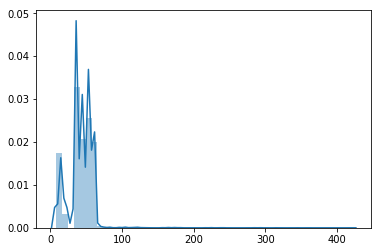

In [6]:
above_med = valid[(valid['seconds'] > 8) & (valid['seconds'] < 600)]

sns.distplot(above_med)

In [7]:
sql = '''
WITH request_interval AS (
SELECT request_date, lead(request_date) over (order by request_date) as next_request
FROM requests
)
SELECT date_trunc('minute', request_date) as request_date, MAX(next_request - request_date) as delay
FROM request_interval
WHERE (request_date::time <= '01:30:00'::time
   OR ((extract(dow from request_date) > 0 AND extract(hour from request_date) >= 6)
   OR (extract(dow from request_date) = 0 AND extract(hour from request_date) >= 8)
   ))
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
df = pd.read_sql(sql, con)
df

,request_date,delay
0,2019-09-28 16:44:00,1 days 17:10:36.623163
1,2019-09-22 21:37:00,0 days 12:41:44.520506
2,2019-09-18 19:05:00,0 days 02:15:00.228746
3,2019-09-13 06:49:00,0 days 00:30:59.997968
4,2019-09-24 14:16:00,0 days 00:06:59.997586
5,2019-09-02 23:43:00,0 days 00:05:44.316046
6,2019-09-18 01:13:00,0 days 00:05:44.270033
7,2019-09-07 07:25:00,0 days 00:05:35.720826
8,2019-09-23 23:56:00,0 days 00:05:22.383986
9,2019-09-07 23:25:00,0 days 00:05:15.998247


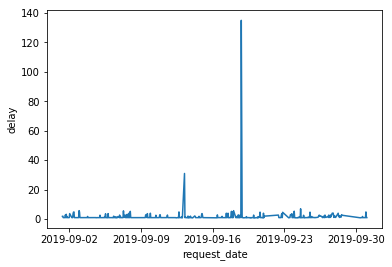

In [8]:
sql = '''
WITH request_interval AS (
SELECT request_date, lead(request_date) over (order by request_date) as next_request
FROM requests
)
SELECT date_trunc('hour', request_date) as request_date, EXTRACT(EPOCH FROM MAX(next_request - request_date))/60 as delay
FROM request_interval
WHERE (request_date::time <= '01:30:00'::time
   OR ((extract(dow from request_date) > 0 AND extract(hour from request_date) >= 6)
   OR (extract(dow from request_date) = 0 AND extract(hour from request_date) >= 8)
   ))
GROUP BY 1
ORDER BY 1
'''
df = pd.read_sql(sql, con)
df1 = df[df['delay'] < 150]

sns.lineplot(x="request_date", y="delay", data=df1)

### Filtered headway

Remove from `headway_data` the rows that are close to an identified API downtime

In [9]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS headway_clean CASCADE; 
CREATE MATERIALIZED VIEW headway_clean AS 
WITH request_interval AS (
SELECT request_date, lead(request_date) over (order by request_date) as next_request
FROM requests
), downtime AS (
SELECT date_trunc('minute', request_date) as minute, EXTRACT(EPOCH FROM MAX(next_request - request_date))/60 as delay
FROM request_interval
WHERE (request_date::time <= '01:30:00'::time
   OR ((extract(dow from request_date) > 0 AND extract(hour from request_date) >= 6)
   OR (extract(dow from request_date) = 0 AND extract(hour from request_date) >= 8)
   ))
GROUP BY 1
HAVING EXTRACT(EPOCH FROM MAX(next_request - request_date))/60 > 3
)
SELECT subwayline, station_char, trainid, timint, requestid, adj_date, request_date, 
  next_train_request_date, next_train_timint
FROM headway_data
LEFT JOIN downtime ON request_date BETWEEN minute - INTERVAL '2 minutes' AND minute + INTERVAL '1 minute'
WHERE minute IS NULL
'''

# with con:
#     with con.cursor() as cur:
#         cur.execute(sql)

In [10]:
sql = '''
SELECT station_char, EXTRACT(EPOCH FROM next_train_request_date-request_date) / 60 as headway
FROM headway_clean
WHERE subwayline = 'BD'
AND RIGHT(station_char, 1) = '1'
'''
df = pd.read_sql(sql, con)
df.groupby('station_char').describe()

headway                                    
               count mean  std  min  25%  50%  75%   max
station_char                                            
BAT1         7511.00 3.81 1.94 0.60 2.13 3.62 5.00 23.74
BAU1         7516.00 3.77 1.94 0.60 2.12 3.39 5.00 18.73
BLO1            0.00  nan  nan  nan  nan  nan  nan   nan
BRD1         7617.00 3.71 1.98 0.60 2.00 3.13 5.00 25.87
BSP1         7891.00 3.62 1.75 0.00 2.13 3.26 4.87 36.40
CFK1         7631.00 3.71 1.96 0.60 2.01 3.25 5.00 33.27
CHE1         7992.00 3.53 2.15 0.25 2.00 3.00 4.88 36.27
CHR1         7493.00 3.81 1.95 0.59 2.13 3.73 5.00 22.13
COX1         8259.00 3.47 2.02 0.60 2.00 3.00 4.87 33.27
DNW1         7694.00 3.71 1.80 0.60 2.25 3.39 4.98 20.87
DON1         7962.00 3.55 2.00 0.60 2.00 3.00 4.88 34.27
DUF1         7761.00 3.69 1.77 0.58 2.13 3.39 4.99 22.73
GWD1         8522.00 3.36 1.96 0.60 2.00 3.00 4.73 16.99
HPK1         7411.00 3.86 2.04 0.60 2.38 3.73 5.00 36.13
ISL1         7124.00 4.02 2.30 0.59 2.74 3.87 5.00 35.76
JNE1         7376.00 3.88 2.01 0.58 2.40 3.76 5.00 34.00
KEL1         7537.00 3.80 1.93 0.60 2.26 3.62 5.00 34.73
KEN1         5435.00 5.26 2.96 0.60 3.13 5.00 7.00 86.12
KIP1         4698.00 6.08 3.12 0.60 4.00 6.00 8.12 36.00
LAN1         7767.00 3.68 1.77 0.59 2.13 3.39 4.88 18.15
MST1         8095.00 3.54 2.03 0.60 2.00 3.00 4.98 26.00
OML1         7380.00 3.88 2.00 0.59 2.40 3.74 5.00 36.00
OSS1         7561.00 3.78 1.86 0.60 2.13 3.73 5.00 22.73
PAP1         7992.00 3.53 2.02 0.08 2.00 3.00 4.87 36.27
RUN1         7408.00 3.86 2.01 0.59 2.27 3.75 5.00 36.00
RYK1         7358.00 3.89 2.02 0.59 2.60 3.86 5.00 34.40
SGL1         7895.00 3.62 1.74 0.00 2.12 3.26 4.87 13.26
SGU1            0.00  nan  nan  nan  nan  nan  nan   nan
SHE1         7587.00 3.74 2.00 0.60 2.01 3.26 5.00 34.00
VPK1         8050.00 3.56 2.06 0.60 2.00 3.00 4.88 33.27
WAR1         8109.00 3.54 2.05 0.60 2.00 3.00 4.87 34.27
WDB1         8100.00 3.54 2.04 0.61 2.00 3.00 4.87 36.13
YNG1         7762.00 3.65 1.88 0.00 2.02 3.13 4.88 36.13

Remove outlier at Kennedy station and replicate boxplot from https://github.com/CivicTechTO/ttc_subway_times/pull/71/files, ordered by station

Text(0.5,1,'Headways for Eastbound Line 2 Trains (EQ1, September 2019)')

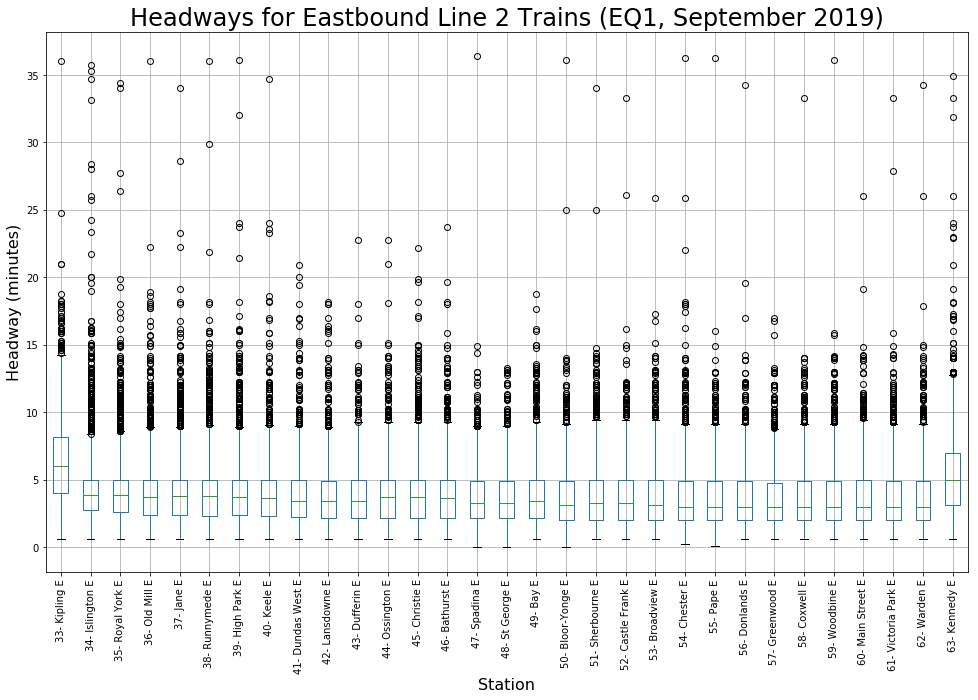

In [11]:
station_names = {
"DWN1": "01- Sheppard West N", "DWN2": "01- Sheppard West S", "WIL1": "02- Wilson N", "WIL2": "02- Wilson S", "YKD1": "03- Yorkdale N", "YKD2": "03- Yorkdale S", "LWW1": "04- Lawrence West N", "LWW2": "04- Lawrence West S", "GCN1": "05- Glencairn N", "GCN2": "05- Glencairn S", "EGW1": "06- Eglinton West N", "EGW2": "06- Eglinton West S", "SCW1": "07- St Clair West N", "SCW2": "07- St Clair West S", "DUP1": "08- Dupont N", "DUP2": "08- Dupont S", "MUS1": "11- Museum N", "MUS2": "11- Museum S", "QPK1": "12- Queen's Park N", "QPK2": "12- Queen's Park S", "STP1": "13- St Patrick N", "STP2": "13- St Patrick S", "OSG1": "14- Osgoode N", "OSG2": "14- Osgoode S", "STA1": "15- St Andrew N", "STA2": "15- St Andrew S", "UNI1": "16- Union N", "UNI2": "16- Union S", "KNG1": "17- King N", "KNG2": "17- King S", "QUN1": "18- Queen N", "QUN2": "18- Queen S", "DUN1": "19- Dundas N", "DUN2": "19- Dundas S", "COL1": "20- College N", "COL2": "20- College S", "WEL1": "21- Wellesley N", "WEL2": "21- Wellesley S", "ROS1": "23- Rosedale N", "ROS2": "23- Rosedale S", "SUM1": "24- Summerhill N", "SUM2": "24- Summerhill S", "STC1": "25- St Clair N", "STC2": "25- St Clair S", "DAV1": "26- Davisville N", "DAV2": "26- Davisville S", "EGL1": "27- Eglinton N", "EGL2": "27- Eglinton S", "LAW1": "28- Lawrence N", "LAW2": "28- Lawrence S", "YKM1": "29- York Mills N", "YKM2": "29- York Mills S", "NYC1": "31- North York Centre N", "NYC2": "31- North York Centre S", "FIN1": "32- Finch N", "FIN2": "32- Finch S", "KIP1": "33- Kipling E", "KIP2": "33- Kipling W", "ISL1": "34- Islington E", "ISL2": "34- Islington W", "RYK1": "35- Royal York E", "RYK2": "35- Royal York W", "OML1": "36- Old Mill E", "OML2": "36- Old Mill W", "JNE1": "37- Jane E", "JNE2": "37- Jane W", "RUN1": "38- Runnymede E", "RUN2": "38- Runnymede W", "HPK1": "39- High Park E", "HPK2": "39- High Park W", "KEL1": "40- Keele E", "KEL2": "40- Keele W", "DNW1": "41- Dundas West E", "DNW2": "41- Dundas West W", "LAN1": "42- Lansdowne E", "LAN2": "42- Lansdowne W", "DUF1": "43- Dufferin E", "DUF2": "43- Dufferin W", "OSS1": "44- Ossington E", "OSS2": "44- Ossington W", "CHR1": "45- Christie E", "CHR2": "45- Christie W", "BAT1": "46- Bathurst E", "BAT2": "46- Bathurst W", "BAU1": "49- Bay E", "BAU2": "49- Bay W", "SHE1": "51- Sherbourne E", "SHE2": "51- Sherbourne W", "CFK1": "52- Castle Frank E", "CFK2": "52- Castle Frank W", "BRD1": "53- Broadview E", "BRD2": "53- Broadview W", "CHE1": "54- Chester E", "CHE2": "54- Chester W", "PAP1": "55- Pape E", "PAP2": "55- Pape W", "DON1": "56- Donlands E", "DON2": "56- Donlands W", "GWD1": "57- Greenwood E", "GWD2": "57- Greenwood W", "COX1": "58- Coxwell E", "COX2": "58- Coxwell W", "WDB1": "59- Woodbine E", "WDB2": "59- Woodbine W", "MST1": "60- Main Street E", "MST2": "60- Main Street W", "VPK1": "61- Victoria Park E", "VPK2": "61- Victoria Park W", "WAR1": "62- Warden E", "WAR2": "62- Warden W", "KEN1": "63- Kennedy E", "KEN2": "63- Kennedy W", "BYV1": "65- Bayview E", "BYV2": "65- Bayview W", "BSS1": "66- Bessarion E", "BSS2": "66- Bessarion W", "LES1": "67- Leslie E", "LES2": "67- Leslie W", "DML1": "68- Don Mills E", "DML2": "68- Don Mills W", "BSP1": "47- Spadina E", "BSP2": "47- Spadina W", "SPA1": "09- Spadina N", "SPA2": "09- Spadina S", "SGL1": "48- St George E", "SGL2": "48- St George W", "SGU1": "10- St George N", "SGU2": "10- St George S", "BLO1": "22- Bloor-Yonge N", "BLO2": "22- Bloor-Yonge S", "YNG1": "50- Bloor-Yonge E", "YNG2": "50- Bloor-Yonge W", "SHP1": "30- Sheppard-Yonge N", "SHP2": "30- Sheppard-Yonge S", "YIE1": "64- Sheppard-Yonge E", "YIE2": "64- Sheppard-Yonge W"
}
stations = df[df['headway'] < 60].replace({"station_char": station_names}, inplace=False)

plt.rcParams["figure.figsize"] = (16,10)
ax = stations.boxplot(column = 'headway', by = 'station_char', rot=90)
fig = ax.get_figure()
fig.suptitle('')
ax.set_xlabel("Station",fontsize=16)
ax.set_ylabel("Headway (minutes)",fontsize=16)
ax.set_title("Headways for Eastbound Line 2 Trains (EQ1, September 2019)",fontsize=24)

Generate csv file with headway data

In [12]:
sql = '''
SELECT *, EXTRACT(EPOCH FROM next_train_request_date-request_date) / 60 as headway
FROM headway_clean
'''
df = pd.read_sql(sql, con)
stations = df.replace({"station_char": station_names}, inplace=False)

stations.to_csv('headway.csv')


In [13]:
stations.count()

subwayline                 1103456
station_char               1103456
trainid                    1103456
timint                     1103456
requestid                  1103456
adj_date                   1103456
request_date               1103456
next_train_request_date    1099518
next_train_timint          1099518
headway                    1099518
dtype: int64